# ConvNet Example

This is a toy to help me learn pytorch

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms



In [2]:
# Use CUDA
use_cuda = torch.cuda.is_available()
#use_cuda=False
cuda_dev_num = 1
cuda_dev = "cuda:" + str(cuda_dev_num)
device = torch.device(cuda_dev if use_cuda else "cpu")
print(device)
if use_cuda:
    print('-', torch.cuda.get_device_name(cuda_dev_num))

cuda:1
- GeForce GTX 980


## Load our data. 

I'm using advice from https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/ about regularizing image data. 


In [3]:
transform = transforms.Compose([transforms.Resize(256),        
                                transforms.CenterCrop(224),    
                                transforms.ToTensor(),         
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                                                     std=[0.229, 0.224, 0.225])
                               ])


datadir = "/home/apower/data/oxford-iiit-pet"
traindir = os.path.join(datadir, 'train')
devdir = os.path.join(datadir, 'dev')
testdir = os.path.join(datadir, 'test')

X_train = torchvision.datasets.ImageFolder(traindir, transform)
X_dev = torchvision.datasets.ImageFolder(devdir, transform)
X_test = torchvision.datasets.ImageFolder(testdir, transform)

num_labels = len(X_train.classes)

print('training_set:', len(X_train), '\ndev_set:', len(X_dev), '\ntest_set:', len(X_test), '\nlabels:', num_labels)

training_set: 5760 
dev_set: 800 
test_set: 800 
labels: 38


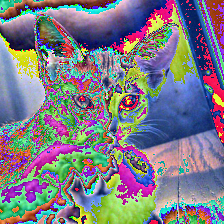

In [4]:
to_pic = torchvision.transforms.ToPILImage()
to_pic(X_train[0][0])

## Let's Build the Model

In [5]:
train_loader = DataLoader(X_train, batch_size=64, shuffle=True, num_workers=4)
dev_loader = DataLoader(X_dev, batch_size=1, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

In [6]:
class TestNet(nn.Module):
    def __init__(self, classes, ):
        super().__init__()
        self.classes = classes
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=16),
                                    nn.ReLU(),
                                    #nn.BatchNorm2d(),
                                    nn.MaxPool2d(kernel_size=16, stride=16),
                                    nn.ReLU(),
                                    #nn.BatchNorm2d(),
                                   )
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
                                    nn.ReLU(),
                                    #nn.BatchNorm2d(),
                                    nn.MaxPool2d(kernel_size=4, stride=4),
                                    nn.ReLU(),
                                    #nn.BatchNorm2d(),
                                   )
        self.fc1 = nn.Sequential(nn.Linear(in_features=512, out_features=classes),
                                 nn.ReLU(),
                                 #nn.BatchNorm2d(),
                                )                
    def forward(self, X):
        #assert X.size() == torch.Size([1, 3, 224, 224]) 
        a1 = self.layer1(X)
        #print('a1.size():', a1.size())
        a2 = self.layer2(a1)
        #print('a2.size():', a2.size())
        a2 = a2.reshape(a2.size(0), -1)
        #print('reshaped a2.size():', a2.size())
        a3 = self.fc1(a2)
        #print('a3.size():', a3.size())
        return a3
        

In [7]:

model = TestNet(num_labels=num_labels)
if use_cuda:
    model = model.to(device)


In [8]:
#local_batch, local_labels = iter(train_loader).__next__()
#X, y = local_batch.to(device), nn.functional.one_hot(local_labels, num_classes).to(device)
#print(X.size(), y.size())
#model.forward(X)

In [9]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [10]:
criterion = nn.CrossEntropyLoss()
OPT = torch.optim.SGD
learning_rate = 0.1
optimizer = OPT(model.parameters(), lr=learning_rate)

losses = [10**10]
max_epochs = 100
for epoch in range(max_epochs):
    batch = 0
    for local_batch, local_labels in train_loader:
        # Transfer to GPU
        X, y = local_batch.to(device), local_labels.to(device)
        y_pred = model.forward(X)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('epoch:', epoch, 'batch:', batch, 'loss:', loss.item())
        batch += 1
    print('epoch:', epoch, 'loss:', loss.item())


epoch: 0 loss: 3.6290459632873535
epoch: 1 loss: 3.619832992553711
epoch: 2 loss: 3.507721185684204
epoch: 3 loss: 3.2139830589294434
epoch: 4 loss: 3.351900339126587
epoch: 5 loss: 3.4426004886627197
epoch: 6 loss: 3.0150182247161865
epoch: 7 loss: 3.0073912143707275
epoch: 8 loss: 3.0125575065612793
epoch: 9 loss: 2.633840560913086
epoch: 10 loss: 3.0432937145233154
epoch: 11 loss: 3.162074327468872
epoch: 12 loss: 2.624171257019043
epoch: 13 loss: 2.8578667640686035
epoch: 14 loss: 2.9427003860473633
epoch: 15 loss: 2.6923093795776367
epoch: 16 loss: 2.810683012008667
epoch: 17 loss: 2.601881265640259
epoch: 18 loss: 2.6980361938476562
epoch: 19 loss: 2.314253807067871
epoch: 20 loss: 2.7181122303009033
epoch: 21 loss: 2.6172847747802734
epoch: 22 loss: 2.1961135864257812
epoch: 23 loss: 3.128749132156372
epoch: 24 loss: 2.13979434967041
epoch: 25 loss: 2.4094626903533936
epoch: 26 loss: 2.267613172531128
epoch: 27 loss: 2.4269025325775146
epoch: 28 loss: 2.3186163902282715
epoch: 2

['Abyssinian']


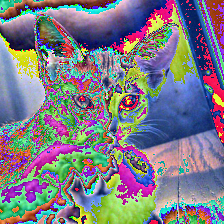

In [11]:
print([c for (c, i) in X_train.class_to_idx.items() if i == X_train.targets[0]])
to_pic(X_train[0][0])


In [13]:
cpu_model = model.to(torch.device('cpu'))
torch.save(cpu_model, 'toy_conv_net_model.pt')


In [14]:
#cpu_model = torch.load('toy_conv_net_model.pt')